## Import Data

In [1]:
import pandas as pd
url1 = "https://assets.datacamp.com/production/repositories/2168/datasets/b1c089b35aa59a7290964640af811125f74fe3ec/LNG.csv"
lng_df = pd.read_csv(url1,parse_dates=['Date'],index_col='Date')
url2 = "https://assets.datacamp.com/production/repositories/2168/datasets/0e72705a29abc4ad16fd29acd0304570ea27111e/SPY.csv"
spy_df = pd.read_csv(url2,parse_dates=['Date'],index_col='Date')

            Adj_Close  Adj_Volume
Date                             
1994-04-04       72.0         0.0
1994-04-05      108.0         0.0
1994-04-06      108.0         0.0
1994-04-07      108.0         0.0
1994-04-08      108.0         0.0
            Adj_Close  Adj_Volume
Date                             
1993-01-29  28.223927   1003200.0
1993-02-01  28.424666    480500.0
1993-02-02  28.484856    201300.0
1993-02-03  28.785997    529400.0
1993-02-04  28.906440    531500.0


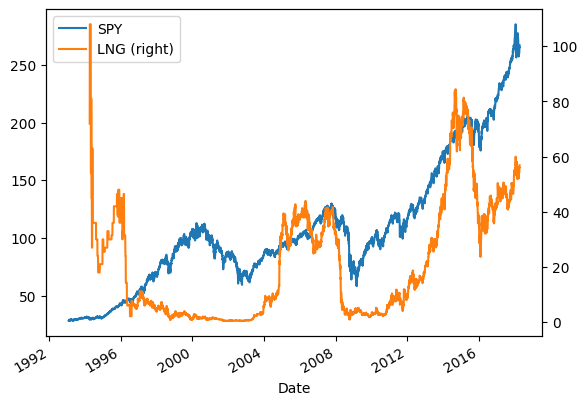

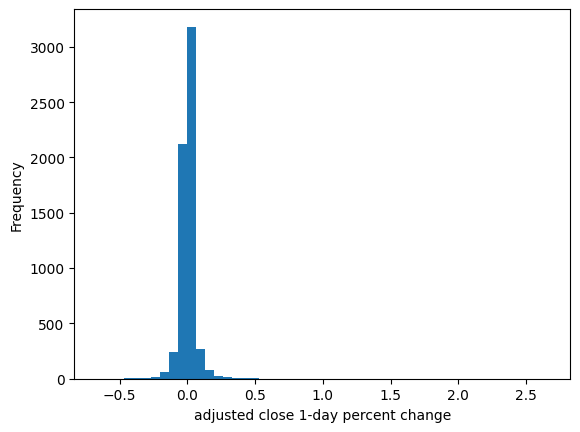

In [2]:
print(lng_df.head())  # examine the DataFrames
print(spy_df.head())  # examine the SPY DataFrame

import matplotlib.pyplot as plt
import seaborn as sns
# Plot the Adj_Close columns for SPY and LNG
spy_df['Adj_Close'].plot(label='SPY', legend=True)
lng_df['Adj_Close'].plot(label='LNG', legend=True, secondary_y=True)
plt.show()  # show the plot
plt.clf()  # clear the plot space

# Histogram of the daily price change percent of Adj_Close for LNG
lng_df['Adj_Close'].pct_change().plot.hist(bins=50)
plt.xlabel('adjusted close 1-day percent change')
plt.show()

## Find correlation

                     5d_close_pct  5d_close_future_pct
5d_close_pct             1.000000            -0.034733
5d_close_future_pct     -0.034733             1.000000


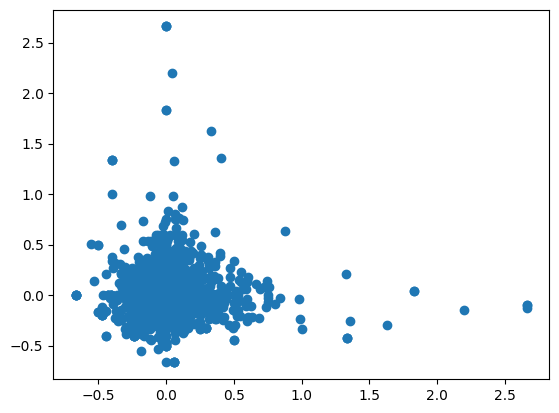

In [3]:
# Create 5-day % changes of Adj_Close for the current day, and 5 days in the future
lng_df['5d_future_close'] = lng_df['Adj_Close'].shift(-5)
lng_df['5d_close_future_pct'] = lng_df['5d_future_close'].pct_change(5)
lng_df['5d_close_pct'] = lng_df['Adj_Close'].pct_change(5)

# Calculate the correlation matrix between the 5d close pecentage changes (current and future)
corr = lng_df[['5d_close_pct', '5d_close_future_pct']].corr()
print(corr)

# Scatter the current 5-day percent change vs the future 5-day percent change
plt.scatter(lng_df['5d_close_pct'], lng_df['5d_close_future_pct'])
plt.show()

In [4]:
# Function to calculate SMA
def calculate_sma(data, window):
    return data.rolling(window=window).mean()


# Function to calculate RSI
def calculate_rsi(data, window):
    diff = data.diff(1)
    gain = diff.where(diff > 0, 0)
    loss = -diff.where(diff < 0, 0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

In [5]:
feature_names = ['5d_close_pct']  # a list of the feature names for later

for n in [14, 30, 50, 200]:
    # Create the moving average indicator and divide by Adj_Close
    lng_df[f'ma{n}'] = calculate_sma(lng_df['Adj_Close'], window=n) / lng_df['Adj_Close']
    
    # Create the RSI indicator
    lng_df[f'rsi{n}'] = calculate_rsi(lng_df['Adj_Close'], window=n)
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + [f'ma{n}', f'rsi{n}']

print(feature_names)

['5d_close_pct', 'ma14', 'rsi14', 'ma30', 'rsi30', 'ma50', 'rsi50', 'ma200', 'rsi200']


In [6]:
# Drop all na values
lng_df = lng_df.dropna()

# Create features and targets
# use feature_names for features; '5d_close_future_pct' for targets
features = lng_df[feature_names]
targets = lng_df['5d_close_future_pct']

# Create DataFrame from target column and feature columns
feature_and_target_cols = ['5d_close_future_pct'] + feature_names
feat_targ_df = lng_df[feature_and_target_cols]

# Calculate correlation matrix
corr = feat_targ_df.corr()

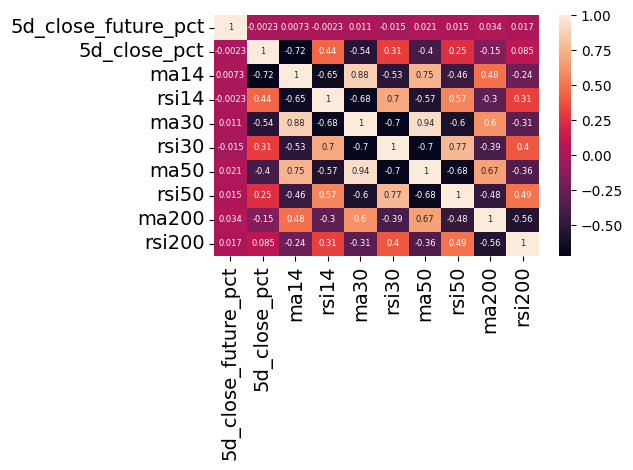

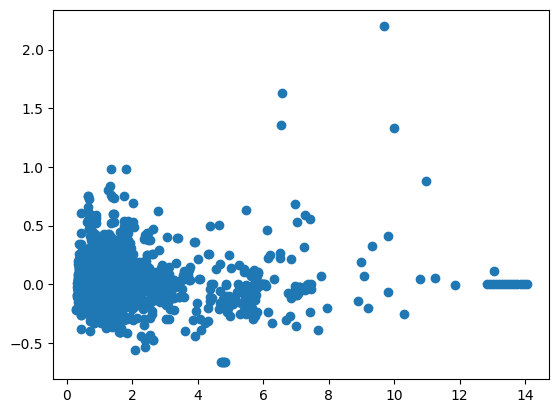

In [7]:
# Plot heatmap of correlation matrix
sns.heatmap(corr, annot=True, annot_kws = {"size": 6})
plt.yticks(rotation=0, size = 14); plt.xticks(rotation=90, size = 14)  # fix ticklabel directions and size
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot
plt.clf()  # clear the plot area

# Create a scatter plot of the most highly correlated variable with the target
plt.scatter(lng_df['ma200'], lng_df['5d_close_future_pct'])
plt.show()

## Enginnering the new feature ##

In [8]:
# Create 2 new volume features, 1-day % change and 5-day SMA of the % change
new_features = ['Adj_Volume_1d_change', 'Adj_Volume_1d_change_SMA']
feature_names.extend(new_features)
lng_df['Adj_Volume_1d_change'] = lng_df['Adj_Volume'].pct_change()
lng_df['Adj_Volume_1d_change_SMA'] = calculate_sma(lng_df['Adj_Volume_1d_change'],
                                               window=5)

In [9]:
days_of_week = pd.get_dummies(lng_df.index.dayofweek,
                              prefix='weekday',
                              drop_first=True)

# Set the index as the original dataframe index for merging
days_of_week.index = lng_df.index

# Join the dataframe with the days of week dataframe
lng_df = pd.concat([lng_df, days_of_week], axis=1)

# Add days of week to feature names
feature_names.extend(['weekday_' + str(i) for i in range(1, 5)])
lng_df.dropna(inplace=True)  # drop missing values in-place
print(lng_df.head())

            Adj_Close  Adj_Volume  5d_future_close  5d_close_future_pct  \
Date                                                                      
1996-09-04       6.76         0.0             6.76             0.000000   
1996-10-04       6.00      2400.0             6.50             0.083333   
1996-10-07       6.26      8200.0             6.12            -0.022364   
1996-10-08       6.26         0.0             6.12            -0.022364   
1996-10-21       5.76      7600.0             5.00            -0.131944   

            5d_close_pct      ma14      rsi14      ma30      rsi30      ma50  \
Date                                                                           
1996-09-04      0.040000  0.978233  44.545455  0.769527  71.886792  0.662426   
1996-10-04     -0.041534  1.041429  29.508197  1.084889  46.198830  0.977733   
1996-10-07      0.043333  0.995436  41.891892  1.038552  46.511628  0.950351   
1996-10-08      0.064626  0.992697  41.891892  1.037274  46.511628  0.9635

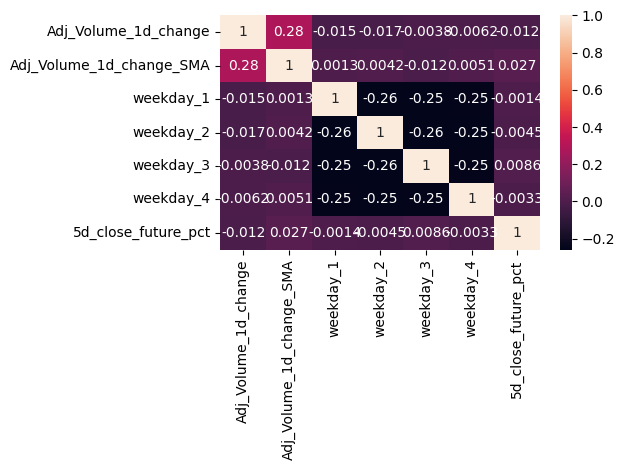

In [10]:
# Add the weekday labels to the new_features list
new_features.extend(['weekday_' + str(i) for i in range(1, 5)])

# Plot the correlations between the new features and the targets
sns.heatmap(lng_df[new_features + ['5d_close_future_pct']].corr(), annot=True)
plt.yticks(rotation=0)  # ensure y-axis ticklabels are horizontal
plt.xticks(rotation=90)  # ensure x-axis ticklabels are vertical
plt.tight_layout()
plt.show()
# Even though the correlations are weak, they may improve our predictions via interactions with other features.

## Random Forest and Gradient Boost ##

In [11]:
from sklearn.model_selection import train_test_split
# Splitting the data
features = lng_df[feature_names]
targets = lng_df['5d_close_future_pct']

train_features, test_features, train_targets, test_targets = train_test_split(lng_df[feature_names], targets, test_size=0.2, random_state=42)

# Print the shapes of the resulting sets
print("X_train shape:", train_features.shape)
print("X_test shape:", test_features.shape)
print("y_train shape:", train_targets.shape)
print("y_test shape:", test_targets.shape)

X_train shape: (4107, 15)
X_test shape: (1027, 15)
y_train shape: (4107,)
y_test shape: (1027,)


In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
import numpy as np

rfr = RandomForestRegressor()

# Create a dictionary of hyperparameters to search
grid = {'n_estimators':[200], 'max_depth': [3], 'max_features': [4,8], 'random_state': [42]}
test_scores = []

# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    rfr.set_params(**g)  # ** is "unpacking" the dictionary
    rfr.fit(train_features, train_targets)
    test_scores.append(rfr.score(test_features, test_targets))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

0.021683857434282916 {'random_state': 42, 'n_estimators': 200, 'max_features': 8, 'max_depth': 3}


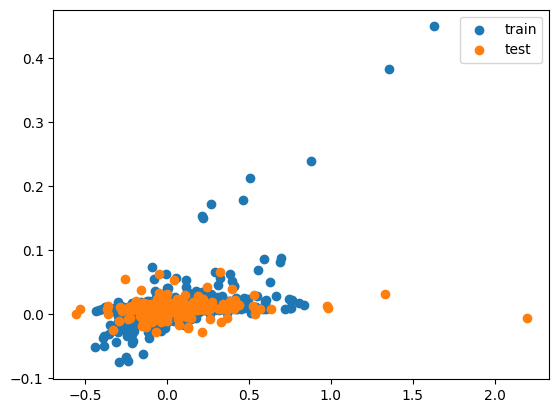

In [13]:
# Use the best hyperparameters from before to fit a random forest model
rfr = RandomForestRegressor(n_estimators=200, max_depth=3, max_features=4, random_state=42)
rfr.fit(train_features, train_targets)

# Make predictions with our model
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# Create a scatter plot with train and test actual vs predictions
plt.scatter(train_targets, train_predictions, label='train')
plt.scatter(test_targets, test_predictions, label='test')
plt.legend()
plt.show()

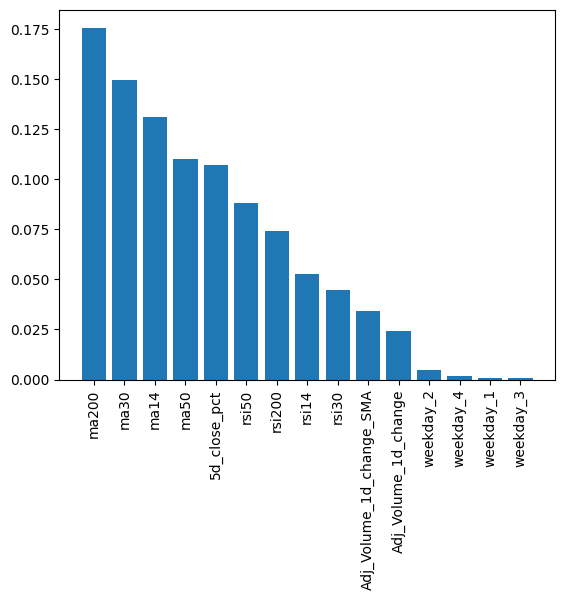

In [14]:
# Get feature importances from our random forest model
importances = rfr.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

In [15]:
from sklearn.ensemble import GradientBoostingRegressor

# Create GB model -- hyperparameters have already been searched for you
gbr = GradientBoostingRegressor(max_features=4,
                                learning_rate=0.01,
                                n_estimators=200,
                                subsample=0.6,
                                random_state=42)
gbr.fit(train_features, train_targets)

print(gbr.score(train_features, train_targets))
print(gbr.score(test_features, test_targets))

0.13692637717270184
0.0353599890997347


## KNN

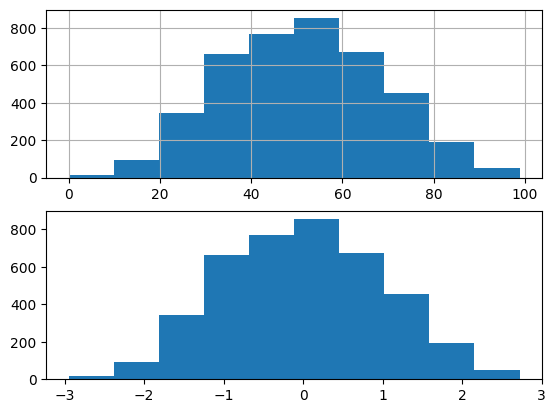

In [16]:
from sklearn.preprocessing import scale

# Remove unimportant features (weekdays)
train_features = train_features.iloc[:, :-4]
test_features = test_features.iloc[:, :-4]

# Standardize the train and test features
scaled_train_features = scale(train_features)
scaled_test_features = scale(test_features)

# Plot histograms of the 14-day SMA RSI before and after scaling
f, ax = plt.subplots(nrows=2, ncols=1)
train_features.iloc[:, 2].hist(ax=ax[0])
ax[1].hist(scaled_train_features[:, 2])
plt.show()

In [17]:
from sklearn.neighbors import KNeighborsRegressor

best_n = None
best_test_score = float('-inf')  # Initialize with negative infinity

for n in range(2, 13):
    # Create and fit the KNN model
    knn = KNeighborsRegressor(n_neighbors=n)
    
    # Fit the model to the training data
    knn.fit(scaled_train_features, train_targets)
    
    # Calculate the scores
    train_score = knn.score(scaled_train_features, train_targets)
    test_score = knn.score(scaled_test_features, test_targets)
    
    # Check if the current test score is the best so far
    if test_score > best_test_score:
        best_test_score = test_score
        best_n = n

print("Best n_neighbors:", best_n)
print("Best test score:", best_test_score)

Best n_neighbors: 4
Best test score: 0.13518363083359686


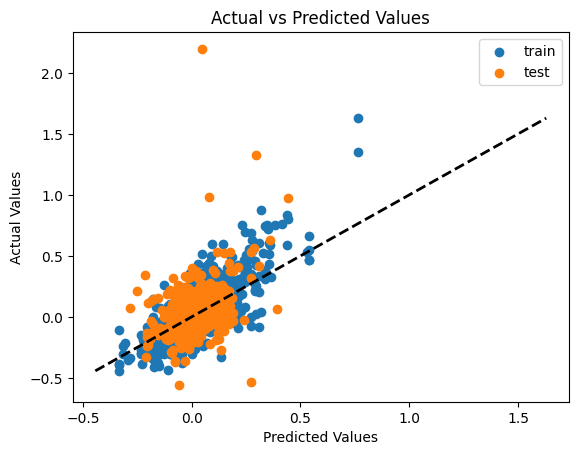

In [18]:
# Create the model with the best-performing n_neighbors of 4
knn = KNeighborsRegressor(n_neighbors=4)

# Fit the model
knn.fit(scaled_train_features, train_targets)

# Get predictions for train and test sets
train_predictions = knn.predict(scaled_train_features)
test_predictions = knn.predict(scaled_test_features)

# Plot the actual vs predicted values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets, label='test')
# Add a 45-degree line
plt.plot([min(train_targets), max(train_targets)], [min(train_targets), max(train_targets)], 'k--', lw=2)

plt.legend()
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Actual vs Predicted Values')
plt.show()

## Neural Networks

In [19]:
from keras.models import Sequential
from keras.layers import Dense

# Create the model
model_1 = Sequential()
model_1.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_1.add(Dense(20, activation='relu'))
model_1.add(Dense(1, activation='linear'))

# Fit the model
model_1.compile(optimizer='adam', loss='mse')
history = model_1.fit(scaled_train_features, train_targets, epochs=25, verbose=0)

2023-12-21 15:33:49.690867: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-21 15:33:55.313273: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


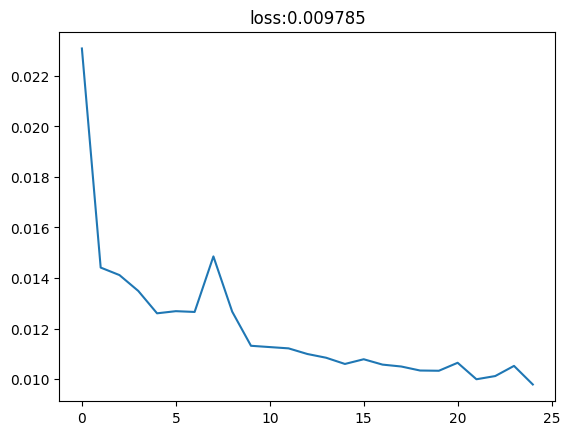

In [20]:
# Plot the losses from the fit
plt.plot(history.history['loss'])

# Use the last loss as the title
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

33/33 [==============================] - 0s 653us/step
0.325584256856027
0.09687238413665922


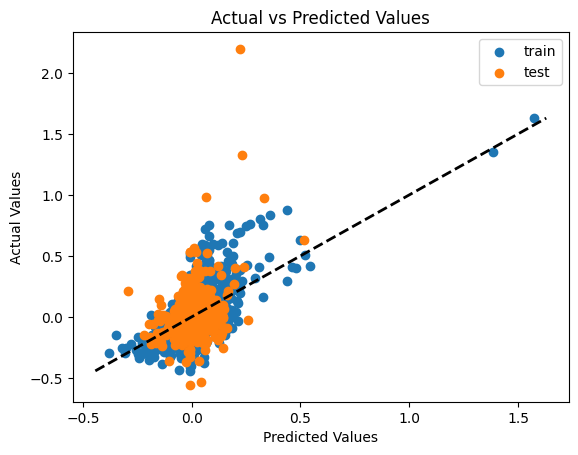

In [21]:
from sklearn.metrics import r2_score

# Calculate R^2 score
train_preds = model_1.predict(scaled_train_features)
test_preds = model_1.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Plot predictions vs actual
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')
# Add a 45-degree line
plt.plot([min(train_targets), max(train_targets)], [min(train_targets), max(train_targets)], 'k--', lw=2)

plt.legend()
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Actual vs Predicted Values')
plt.show()

### Custom loss function

In [22]:
import keras.losses
import tensorflow as tf

# Create loss function
def sign_penalty(y_true, y_pred):
    penalty = 100
    loss = tf.where(tf.less(y_true * y_pred, 0), \
                     penalty * tf.square(y_true - y_pred), \
                     tf.square(y_true - y_pred))

    return tf.reduce_mean(loss, axis=-1)

keras.losses.sign_penalty = sign_penalty  # enable use of loss with keras
print(keras.losses.sign_penalty)

<function sign_penalty at 0x13ef95000>


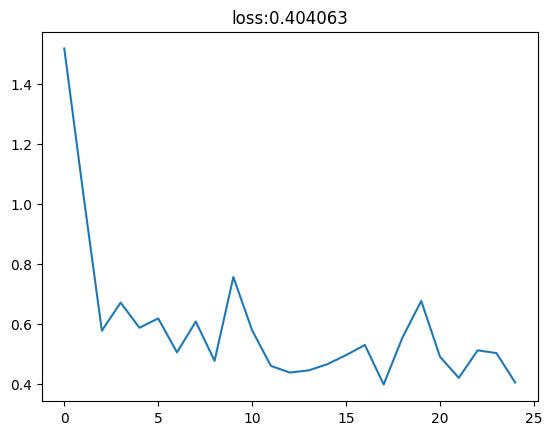

In [23]:
# Create the model
model_2 = Sequential()
model_2.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_2.add(Dense(20, activation='relu'))
model_2.add(Dense(1, activation='linear'))

# Fit the model with our custom 'sign_penalty' loss function
model_2.compile(optimizer='adam', loss=sign_penalty)
history = model_2.fit(scaled_train_features, train_targets, epochs=25,verbose=0)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

33/33 [==============================] - 0s 598us/step
0.07000319132204069
0.040403397021289256


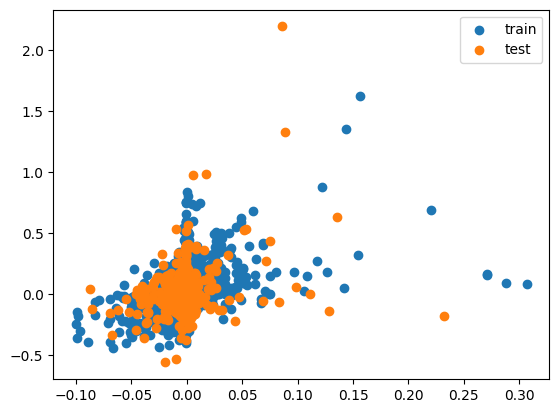

In [24]:
# Evaluate R^2 scores
train_preds = model_2.predict(scaled_train_features)
test_preds = model_2.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Scatter the predictions vs actual -- this one is interesting!
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')
plt.legend(); plt.show()

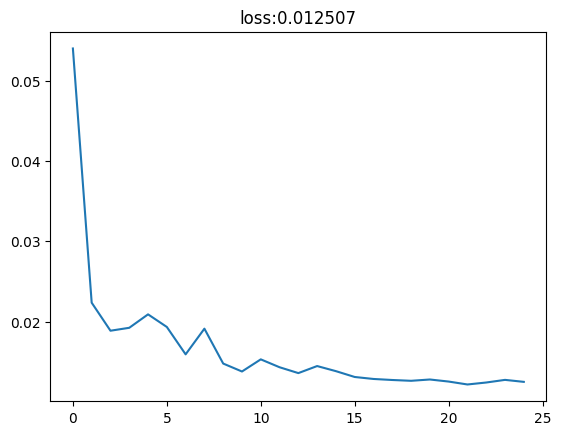

In [25]:
from keras.layers import Dropout

# Create model with dropout
model_3 = Sequential()
model_3.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(20, activation='relu'))
model_3.add(Dense(1, activation='linear'))

# Fit model with mean squared error loss function
model_3.compile(optimizer='adam', loss='mse')
history = model_3.fit(scaled_train_features, train_targets, epochs=25, verbose=0)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

## Machine learning with modern portfolio theory

### Plot Efficent Frontier

In [26]:
# Join 2 stock dataframes together
aapl_url = 'https://assets.datacamp.com/production/repositories/2168/datasets/3748d04d5afec762dab8d26dee3844c0f8f8f540/AAPL.csv'
amd_url = 'https://assets.datacamp.com/production/repositories/2168/datasets/91af558c2465d48fb15c687a2d22a5abf2b64984/AMD.csv'
qqq_url = 'https://assets.datacamp.com/production/repositories/2168/datasets/33592b2d41dd5448a92994f63b84a68b669fadc7/QQQ.csv'

aapl_df = pd.read_csv(aapl_url,parse_dates=['Date'],index_col='Date',usecols=['Date','Adj_Close']).rename(columns={'Adj_Close': 'aapl'})
amd_df = pd.read_csv(amd_url,parse_dates=['Date'],index_col='Date',usecols=['Date','Adj_Close']).rename(columns={'Adj_Close': 'amd'})
qqq_df = pd.read_csv(qqq_url,parse_dates=['Date'],index_col='Date',usecols=['Date','Adj_Close']).rename(columns={'Adj_Close': 'qqq'})

full_df = pd.concat([aapl_df, amd_df, qqq_df], axis=1).dropna()

# Resample the full dataframe to monthly timeframe
monthly_df = full_df.resample('BMS').first()

# Calculate daily returns of stocks
returns_daily = full_df.pct_change()

# Calculate monthly returns of the stocks
returns_monthly = monthly_df.pct_change().dropna()
print(returns_monthly.tail())

                aapl       amd       qqq
Date                                    
2017-10-02 -0.062420 -0.036391 -0.000689
2017-11-01  0.085040 -0.150275  0.044786
2017-12-01  0.028623 -0.006481  0.015713
2018-01-01  0.007074  0.023299  0.028022
2018-02-01 -0.026007  0.206740  0.059751


In [43]:
# Daily covariance of stocks (for each monthly period)
covariances = {}
rtd_idx = returns_daily.index
for i in returns_monthly.index:    
    # Mask daily returns for each month and year, and calculate covariance
    mask = (rtd_idx.month == i.month) & (rtd_idx.year == i.year)
    
    # Use the mask to get daily returns for the current month and year of monthy returns index
    covariances[i] = returns_daily[mask].cov()
first_key = next(iter(covariances))    
covariances[first_key],first_key

/usr/local/lib/python3.10/site-packages/pandas/core/frame.py:10464: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/lib/python3.10/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


(          aapl       amd       qqq
 aapl  0.000338  0.000458  0.000306
 amd   0.000458  0.001788  0.000715
 qqq   0.000306  0.000715  0.000378,
 Timestamp('2011-11-01 00:00:00', freq='BMS'))

In [49]:
portfolio_returns, portfolio_volatility, portfolio_weights = {}, {}, {}

# Get portfolio performances at each month
for date in sorted(covariances.keys()):
    cov = covariances[date]
    for portfolio in range(5000):
        weights = np.random.random(3)
        weights /= np.sum(weights) # /= divides weights by their sum to normalize
        returns = np.dot(weights, returns_monthly.loc[date])
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        portfolio_returns.setdefault(date, []).append(returns)
        portfolio_volatility.setdefault(date, []).append(volatility)
        portfolio_weights.setdefault(date, []).append(weights)
        
print(portfolio_weights[date][0])

[0.01092584 0.52544242 0.46363174]


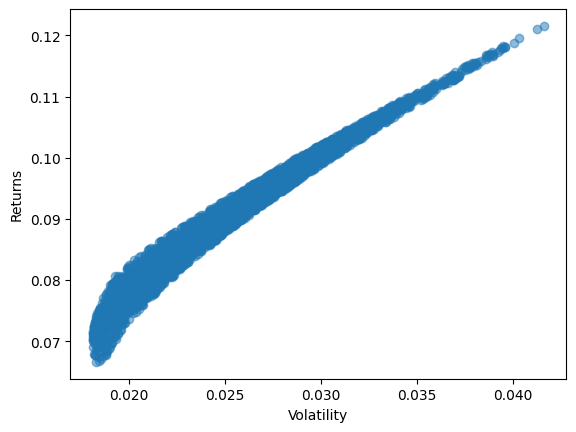

In [50]:
# Get latest date of available data
date = sorted(covariances.keys())[0]  

# Plot efficient frontier
# warning: this can take at least 10s for the plot to execute...
plt.scatter(x=portfolio_volatility[date], y=portfolio_returns[date],  alpha=0.5)
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.show()

### Using sharpe ratio to uptimize

In [51]:
# Empty dictionaries for sharpe ratios and best sharpe indexes by date
sharpe_ratio, max_sharpe_idxs = {}, {}

# Loop through dates and get sharpe ratio for each portfolio
for date in portfolio_returns.keys():
    for i, ret in enumerate(portfolio_returns[date]):
    
        # Divide returns by the volatility for the date and index, i
        sharpe_ratio.setdefault(date, []).append(ret / portfolio_volatility[date][i])

    # Get the index of the best sharpe ratio for each date
    max_sharpe_idxs[date] = np.argmax(sharpe_ratio[date])

print(portfolio_returns[date][max_sharpe_idxs[date]])

0.13604821442814308


In [52]:
# Calculate exponentially-weighted moving average of daily returns
ewma_daily = returns_daily.ewm(span=30).mean()

# Resample daily returns to first business day of the month with the first day for that month
ewma_monthly = ewma_daily.resample('BMS').first()

# Shift ewma for the month by 1 month forward so we can use it as a feature for future predictions 
ewma_monthly = ewma_monthly.shift(1).dropna()

print(ewma_monthly.iloc[-1])

aapl    0.000479
amd     0.001888
qqq     0.001385
Name: 2018-02-01 00:00:00, dtype: float64


### Calculate features and targets

In [54]:
targets, features = [], []

# Create features from price history and targets as ideal portfolio
for date, ewma in ewma_monthly.iterrows():

    # Get the index of the best sharpe ratio
    best_idx = max_sharpe_idxs[date]
    targets.append(portfolio_weights[date][best_idx])
    features.append(ewma)  # add ewma to features

targets = np.array(targets)
features = np.array(features)
print(targets[-5:])

[[9.76934503e-05 1.50468664e-02 9.84855440e-01]
 [4.34418491e-01 9.95581848e-05 5.65481950e-01]
 [4.79104532e-01 7.94681703e-04 5.20100787e-01]
 [2.17618500e-02 1.31691761e-02 9.65068974e-01]
 [1.09258352e-02 5.25442421e-01 4.63631744e-01]]


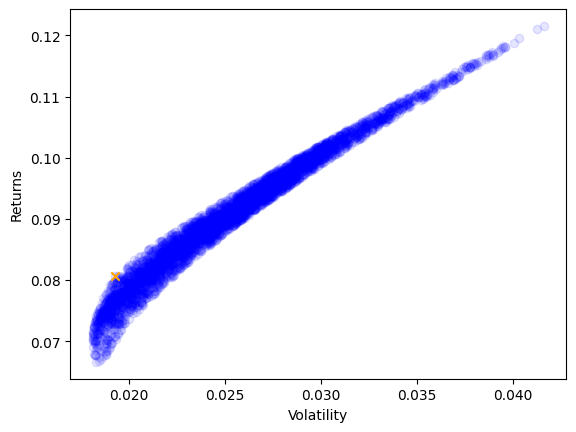

In [56]:
# Get most recent (current) returns and volatility
date = sorted(covariances.keys())[0]
cur_returns = portfolio_returns[date]
cur_volatility = portfolio_volatility[date]

# Plot efficient frontier with sharpe as point
plt.scatter(x=cur_volatility, y=cur_returns, alpha=0.1, color='blue')
best_idx = max_sharpe_idxs[date]

# Place an orange "X" on the point with the best Sharpe ratio
plt.scatter(x=cur_volatility[best_idx], y=cur_returns[best_idx], marker='x', color='orange')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.show()

### make prediction with random forest

In [57]:
# Make train and test features
train_size = int(0.85 * features.shape[0])
train_features = features[:train_size]
test_features = features[train_size:]
train_targets = targets[:train_size]
test_targets = targets[train_size:]

# Fit the model and check scores on train and test
rfr = RandomForestRegressor(n_estimators=300, random_state=42)
rfr.fit(train_features, train_targets)
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features, test_targets))

0.8286198317505514
-0.374608388349164


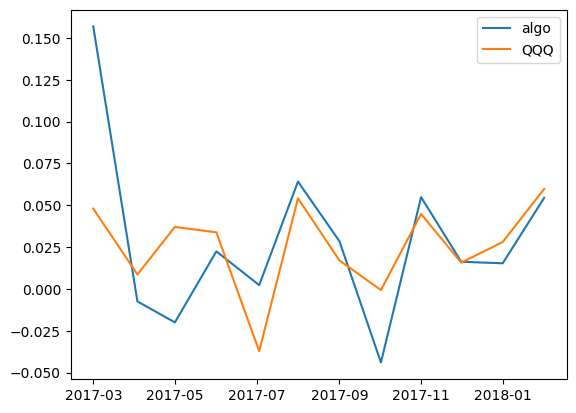

In [60]:
# Get predictions from model on train and test
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# Calculate and plot returns from our RF predictions and the SPY returns
test_returns = np.sum(returns_monthly.iloc[train_size:] * test_predictions, axis=1)
plt.plot(test_returns, label='algo')
plt.plot(returns_monthly['qqq'].iloc[train_size:], label='QQQ')
plt.legend()
plt.show()

In [61]:
# Calculate the effect of our portfolio selection on a hypothetical $1k investment
cash = 1000
algo_cash, qqq_cash = [cash], [cash]  # set equal starting cash amounts
for r in test_returns:
    cash *= 1 + r
    algo_cash.append(cash)

# Calculate performance for SPY
cash = 1000  # reset cash amount
for r in returns_monthly['qqq'].iloc[train_size:]:
    cash *= 1 + r
    qqq_cash.append(cash)

print('algo returns:', (algo_cash[-1] - algo_cash[0]) / algo_cash[0])
print('QQQ returns:', (qqq_cash[-1] - qqq_cash[0]) / qqq_cash[0])

algo returns: 0.38454433023421414
QQQ returns: 0.35128946483136814


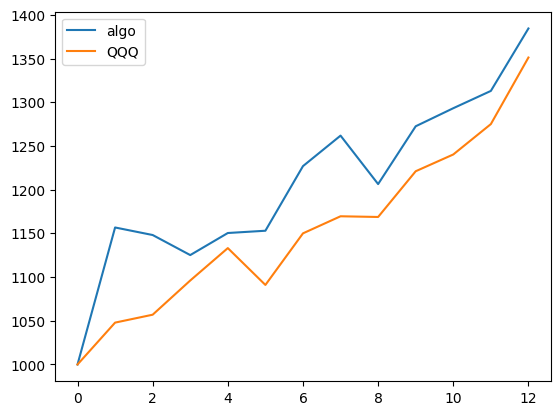

In [62]:
# Plot the algo_cash and spy_cash to compare overall returns
plt.plot(algo_cash, label='algo')
plt.plot(qqq_cash, label='QQQ')
plt.legend()  # show the legend
plt.show()